In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
%matplotlib inline
sns.set()
np.random.seed(1)

In [4]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
import multiprocessing
class MLTester(object):
    def __init__(self, estimator, x, y, scoring_method, n_jobs=1, splitting_method=None, splitting_method_params=None, groups=None):
        """

        :param estimator: estimator object

                    This is assumed to implement the scikit-learn estimator interface.

        :param x: array-like, shape (n_samples, n_features)

                    Training data, where n_samples is the number of samples and n_features is the number of features.

        :param y: array-like, shape (n_samples,)

                    The target variable for supervised learning problems.

        :param scoring_method: string

                    A single string to evaluate the predictions on the test set.

                    see http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter for more info.

        :param n_jobs: int, default=1

                    Number of jobs to run in parallel.

        :param splitting_method: callable

                    A splitting function from scikit-learn's model_selection sub-module.

                    Like LeavePOut, KFold, TimeSeriesSplit etc ...

        :param splitting_method_params: dict

                    Parameters for the splitting_methods provided function.

                    Like n_splits, max_train_size etc ...

        :param groups: array-like, with shape (n_samples,), optional, for some splitting_methods it's ignored.

                    Group labels for the samples used while splitting the dataset into train/test set.
        """
        self.estimator = estimator
        self.x = x
        self.y = y
        self.scoring_method = scoring_method
        # -1 indicates we want all the cores and if we pass multiprocessing.Pool() a None it will use all the cores:
        self.n_jobs = None if n_jobs == -1 else n_jobs
        self.splitting_method = splitting_method
        self.splitting_method_params = splitting_method_params
        self.groups = groups

    def single_model_run(self, x_train, x_test, y_train, y_test):
        """
        Fit the estimator and get the score (based on the scoring method given) on the train and test data.

        :param x_train: array-like, shape (n_samples, n_features)

                    Training data for fitting the model / estimator).

                    where n_samples is the number of samples and n_features is the number of features.

        :param x_test:array-like, shape (n_samples, n_features)

                    Training data for testing the model / estimator).

                    where n_samples is the number of samples and n_features is the number of features.

        :param y_train: array-like, shape (n_samples,)

                The target variable for fitting the model / estimator

        :param y_test: array-like, shape (n_samples,)

                The target variable for testing the model / estimator.

        :return: Tuple
                (train score, test score)
        """
        self.estimator.fit(x_train, y_train)

        train_score = metrics.get_scorer(self.scoring_method)(self.estimator, x_train, y_train)
        test_score = metrics.get_scorer(self.scoring_method)(self.estimator, x_test, y_test)

        return train_score, test_score

    def _split_x_and_y(self):
        """
        Splits the provided x and y data by the provided splitting_method.

        :return: List containing train-test split of inputs.
        """
        split_data_and_target = []
        for train_index, test_index in self.splitting_method(**self.splitting_method_params).split(self.x, self.y,
                                                                                                   self.groups):
            x_train, x_test = self.x.iloc[train_index], self.x.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]

            split_data_and_target.append([x_train, x_test, y_train, y_test])

        return split_data_and_target

    def run(self):
        """
        Run the full testing.
        Split the given X and y based on the splitting_method.
        Fit and estimate your given model in parallel (n_jobs).

        :return: a Pandas' DataFrame
        """
        input_to_multi = self._split_x_and_y()
        with multiprocessing.Pool(self.n_jobs) as p:
            results = p.starmap(self.single_model_run, input_to_multi)

        return pd.DataFrame(results,
                            columns=[f'train_{self.scoring_method}', f'test_{self.scoring_method}']).describe()


In [36]:
def clean_song_artist(song_lyrics):
    song_lyrics = re.sub(r'\[.+\]', '', str(song_lyrics).lower())
    return re.sub('[^\w\s]', '', song_lyrics)

In [21]:
data = pd.read_excel(r'lyrics.xlsx')
data.head()

,lyrics,artist,rapper_type
0,"\n\n[Intro: Jay Z]\nUhh, uhh, uhh\nYou ready, ...",2pac,old_school_rappers
1,\n\n[Intro]\nDeath Row\nThat's where mothafuck...,2pac,old_school_rappers
2,\n\n[Verse 1]\nI'm caught up in this sickness\...,2pac,old_school_rappers
3,"\n\n[Hook: C-Bo] (2X)\nWest side, it's 187 on ...",2pac,old_school_rappers
4,"\n\nWoman – Sir, will you raise your right han...",2pac,old_school_rappers


# Analysis

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 3 columns):
lyrics         1960 non-null object
artist         2000 non-null object
rapper_type    2000 non-null object
dtypes: object(3)
memory usage: 62.5+ KB


# todo: why there are nulls?

In [23]:
data[data['lyrics'].isnull()]

,lyrics,artist,rapper_type
10,NaN,2pac,old_school_rappers
59,NaN,2pac,old_school_rappers
135,NaN,Jay-Z,old_school_rappers
136,NaN,Jay-Z,old_school_rappers
184,NaN,Jay-Z,old_school_rappers
185,NaN,Jay-Z,old_school_rappers
535,NaN,Ice Cube,old_school_rappers
584,NaN,Ice Cube,old_school_rappers
617,NaN,Snoop Dogg,old_school_rappers
667,NaN,Snoop Dogg,old_school_rappers


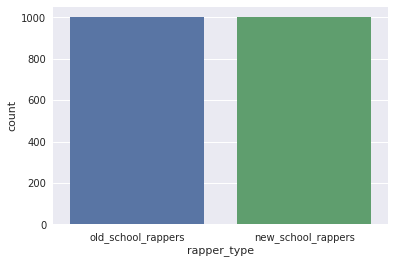

In [14]:
sns.countplot(data=data, x='rapper_type');

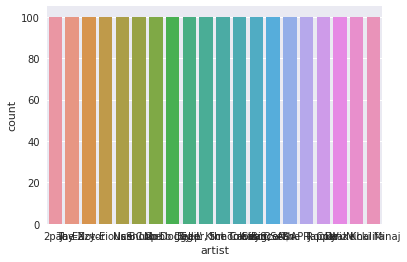

In [15]:
sns.countplot(data=data, x='artist');

In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud_plot(text):
    # Create stopword list:
    stopwords = set(STOPWORDS)

    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [25]:
data["lyrics"] = data["lyrics"].apply(clean_song_artist)

In [34]:
data.head()

,lyrics,artist,rapper_type
0,\n\nintro jay z\nuhh uhh uhh\nyou ready b\nlet...,2pac,old_school_rappers
1,\n\nintro\ndeath row\nthats where mothafuckas ...,2pac,old_school_rappers
2,\n\nverse 1\nim caught up in this sickness\ni ...,2pac,old_school_rappers
3,\n\nhook cbo 2x\nwest side its 187 on a mother...,2pac,old_school_rappers
4,\n\nwoman sir will you raise your right hand ...,2pac,old_school_rappers


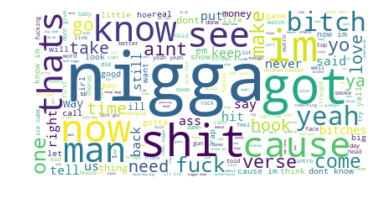

In [26]:
word_cloud_plot(' '.join(data['lyrics']).replace('\n', ' '))

# ML

In [27]:
X = data['lyrics']
y = data['rapper_type']

In [30]:
model = Pipeline(
        [
            ('vec', text.TfidfVectorizer(binary=True, stop_words='english')),
            ('logreg', LogisticRegression())
        ]
    )

score = MLTester(model, X, y, scoring_method='f1_weighted', n_jobs=3, splitting_method=RepeatedStratifiedKFold,
                 splitting_method_params={'n_splits': 5}).run()

In [31]:
score

,train_f1_weighted,test_f1_weighted
count,50.000000,50.000000
mean,0.978681,0.951704
std,0.001513,0.010365
min,0.975617,0.924848
25%,0.977492,0.947431
50%,0.978742,0.952441
75%,0.979995,0.959965
max,0.981246,0.972498


In [33]:
import eli5
model.fit(X, y)

eli5.show_weights(model)

/home/ariel/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Weight?,Feature
+1.689,cube
+1.649,kim
+1.639,dogg
+1.541,yo
+1.474,notorious
+1.459,snoop
+1.344,check
+1.293,black
+1.258,tryin
+1.223,bust
